In [1]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy


## Convenience functions

### Parallelization

In [43]:


def parallelize(
    function,
    iterable,
    num_cores,
    num_entries,
    completion_message="Parallelization complete.",
    termination_message="Parallelization manually terminated.",
    error_message="Parallelization terminated due to error.",
    use_tqdm=True,
):
    try:
        pool = multiprocessing.Pool(processes=num_cores)
        if use_tqdm:
            x = list(tqdm(pool.imap(function, iterable), total=num_entries))  # hacky
        else:
            x = pool.map(function, iterable)
        pool.close()
        pool.join()
        log.info(completion_message)
    except KeyboardInterrupt:
        log.warning(termination_message)
        pool.terminate()
        pool.join()
    except ValueError:
        log.warning(error_message)
        pool.terminate()
        pool.join()
    return x


### Reduced parameters

In [2]:
def encode_xy_tele_1d(kon,koff,kinit,beta):
    kappa = kon+koff
    K_avg = kon*kinit/kappa
    x = kappa/(kappa+beta)
    a = kon*kappa/koff
    theta = koff*kinit/kappa
    y = theta/(theta+a)
    return x,y,K_avg,beta

def encode_xy_sde_1d(a,kappa,theta,beta):
    K_avg = a*theta/kappa
    x = kappa/(kappa+beta)
    y = theta/(theta+a)
    return x,y,K_avg,beta

def decode_xy_tele_1d(x, y, K_avg, beta):
    kappa = (beta)*(x/(1-x))
    ath = 1/y - 1
    c = K_avg*ath/kappa
    kon = np.sqrt(c) * kappa/ (np.sqrt(c) + 1)
    koff = kappa / (np.sqrt(c) + 1)
    kinit = K_avg * kappa / kon
    return kon,koff,kinit, beta
def decode_xy_sde_1d(x, y, K_avg, beta):
    kappa = (beta)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    return a, kappa, theta, beta


In [3]:
def encode_xy_tele_2d(kon,koff,kinit,beta,gamma):
    kappa = kon+koff
    K_avg = kon*kinit/kappa
    x = kappa/(kappa+beta+gamma)
    a = kon*kappa/koff
    theta = koff*kinit/kappa
    y = theta/(theta+a)
    return x,y,K_avg,beta,gamma

def encode_xy_sde_2d(a,kappa,theta,beta,gamma):
    K_avg = a*theta/kappa
    x = kappa/(kappa+beta+gamma)
    y = theta/(theta+a)
    return x,y,K_avg,beta,gamma

def decode_xy_tele_2d(x,y,K_avg,beta,gamma):
    kappa = (beta+gamma)*(x/(1-x))
    ath = 1/y - 1
    c = K_avg*ath/kappa
    kon = np.sqrt(c) * kappa/ (np.sqrt(c) + 1)
    koff = kappa / (np.sqrt(c) + 1)
    kinit = K_avg * kappa / kon
    return kon,koff,kinit,beta,gamma

def decode_xy_sde_2d(x, y, K_avg, beta,gamma):
    kappa = (beta + gamma)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    return a,kappa,theta,beta,gamma


### The switching model

In [4]:
class TelegraphModel():
    """
    This collection of convenience functions is placed in its own class mostly to avoid function name conflicts.
    The code is largely reused from JJV's thesis and "Analytic solution of chemical master equations 
    involving gene switching. I: Representation theory and diagrammatic approach to exact solution."
    """
    def __init__(self):
        pass


    # First ODE for 2 species model
    def f1_2sp(self,q1, q2, t, c0, c1, params):
        alpha_1, alpha_2, beta_0, beta_1, k_12, k_21 = params[0], params[1], params[2], params[3], params[4], params[5]

        result = - k_21*q1 + k_21*q2 + alpha_1*(c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t))*q1
        return result

    # Second ODE for 2 species model
    def f2_2sp(self,q1, q2, t, c0, c1, params):
        alpha_1, alpha_2, beta_0, beta_1, k_12, k_21 = params[0], params[1], params[2], params[3], params[4], params[5]

        result = k_12*q1 - k_12*q2 + alpha_2*(c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t))*q2
        return result


    # RK4 implementation for 2 species model
    def RK4_2sp(self,q1, q2, f1_b, f2_b, t, g0, g1, step_size, param):
        j1 = f1_b(q1, q2, t, g0, g1, param)
        h1 = f2_b(q1, q2, t, g0, g1, param)

        j2 = f1_b(q1 + (step_size/2)*j1, q2 + (step_size/2)*h1, t + (step_size/2), g0, g1, param)
        h2 = f2_b(q1 + (step_size/2)*j1, q2 + (step_size/2)*h1, t + (step_size/2), g0, g1, param)

        j3 = f1_b(q1 + (step_size/2)*j2, q2 + (step_size/2)*h2, t + (step_size/2), g0, g1, param)
        h3 = f2_b(q1 + (step_size/2)*j2, q2 + (step_size/2)*h2, t + (step_size/2), g0, g1, param)

        j4 = f1_b(q1 + (step_size)*j3, q2 + (step_size)*h3, t + (step_size), g0, g1, param)
        h4 = f2_b(q1 + (step_size)*j3, q2 + (step_size)*h3, t + (step_size), g0, g1, param)

        q1_new = q1 + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
        q2_new = q2 + (step_size/6)*(h1 + 2*h2 + 2*h3 + h4)    

        return q1_new, q2_new


    # Get generating function for 2 species model (unspliced and spliced) via ODE method
    def get_gf_bds_2sp_ODE(self,g0, g1, params):
        # get parameters
        alpha_1, alpha_2, beta_0, beta_1, k_12, k_21 = params[0], params[1], params[2], params[3], params[4], params[5]
        s = k_12 + k_21

        c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       # q coefficients
        c1 = - (beta_0/(beta_1 - beta_0))*(g1)       

        max_fudge = 10                                              # Determine integration time scale / length
        t_max = np.max([1/beta_0, 1/beta_1])*max_fudge
        min_fudge = 1
        dt = np.min([1/s, 1/beta_0, 1/beta_1, 1/np.max([alpha_1, alpha_2])])*min_fudge
        num_tsteps = int(np.ceil(t_max/dt))


        q1 = np.ones(g0.shape, dtype=np.complex64)    # initialize array to store ODE
        q2 = np.ones(g0.shape, dtype=np.complex64)

        # Solve ODE using RK4
        for i in range(0, num_tsteps):
            t = i*dt
            q1, q2 = self.RK4_2sp(q1, q2, self.f1_2sp, self.f2_2sp, t, c0, c1, dt, params)
        gf = (k_12/s)*q1 + (k_21/s)*q2
        return gf


    # Get Pss for 2 species model (unspliced and spliced) via ODE method
    def get_Pss_bds_2sp_ODE(self,mx, params):
        # Get generating function argument
        u = []
        half = mx[:]
        half[-1] = mx[-1]//2 + 1
        for i in range(len(mx)):
            l = np.arange(half[i])
            u_ = np.exp(-2j*np.pi*l/mx[i])-1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
        for i in range(len(mx)):
            g[i] = g[i].flatten()

        # Get generating function
        gf = self.get_gf_bds_2sp_ODE(g[0], g[1], params)                    
        gf = gf.reshape(tuple(half))


        Pss = scipy.fft.irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
        return Pss

    def get_Pss(self,kon,koff,kinit,beta,gamma,mx):
        params = (kinit,0, beta, gamma, kon, koff)
        Pss = self.get_Pss_bds_2sp_ODE(mx, params)
        Pss = np.abs(Pss)
        Pss /= Pss.sum()
        return Pss

### Gamma-OU

In [5]:
class GOUModel():
    """
    This collection of convenience functions is largely reused from 
    "Interpretable and tractable models of transcriptional noise for the 
    rational design of single-molecule quantification experiments".
    """
    def __init__(self):
        pass
    def get_GOU_2sp(self,mx, params):
        u = []
        half = mx[:]
        half[-1] = mx[-1]//2 + 1
        for i in range(len(mx)):
            l = np.arange(half[i])
            u_ = np.exp(-2j*np.pi*l/mx[i])-1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
        for i in range(len(mx)):
            g[i] = g[i].flatten()

        # Get generating function
        gf = self.get_gf_GOU_2sp_ODE(g[0], g[1], params)                    
        gf = gf.reshape(tuple(half))

        Pss = scipy.fft.irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
        Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
        return Pss

    def get_gf_GOU_2sp_ODE(self,g0, g1, params):
        beta_0, beta_1, a, kappa, theta = params     # get parameters

        c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
        c1 = - (beta_0/(beta_1 - beta_0))*(g1)   

        min_fudge, max_fudge = 0.25, 10                                     # Determine integration time scale / length
        dt = np.min([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*min_fudge
        t_max = np.max([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*max_fudge
        num_tsteps = int(np.ceil(t_max/dt))
        t_array = np.linspace(0, t_max, num_tsteps+1)
        t_array = t_array.reshape((1, num_tsteps + 1))

        q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
        c0 = c0.reshape((c0.shape[0],1))
        c1 = c1.reshape((c1.shape[0],1))
        q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
        q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
        q = q0 + q1


        integrand = q/(1-q)
        integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
        gf = np.exp( a*integral)               # get generating function
        return gf
    
    def get_Pss(self,a,kappa,theta,beta,gamma,mx):
        params = beta, gamma, a, kappa, theta
        if np.any((np.asarray(params)<=0) | (~np.isfinite(params))):
            raise ValueError

        Pss = self.get_GOU_2sp(mx, params)
        Pss = np.abs(Pss)
        Pss /= Pss.sum()
        return Pss

### CIR 

In [6]:
class CIRModel():
    """
    This collection of convenience functions is largely reused from 
    "Interpretable and tractable models of transcriptional noise for the 
    rational design of single-molecule quantification experiments".
    """
    def __init__(self):
        pass
    # ODE for 2 species CIR model
    def f_2sp(self,q, t, c0, c1, params):
        beta_0, beta_1, a, kappa, theta = params
        result = - kappa*q + theta*q*q + kappa*( c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t)  ) 
        return result


    # Vectorized RK4 implementation for 2 species CIR model
    def RK4_2sp(self,q, f, t, c0, c1, step_size, param):
        j1 = f(q, t, c0, c1, param)
        j2 = f(q + (step_size/2)*j1, t + (step_size/2), c0, c1, param)   
        j3 = f(q + (step_size/2)*j2, t + (step_size/2), c0, c1, param)   
        j4 = f(q + (step_size)*j3, t + (step_size), c0, c1, param)  

        q_new = q + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
        return q_new


    # Get 2 species CIR generating function using ODE method
    def get_gf_CIR_2sp(self,g0, g1, params):
        beta_0, beta_1, a, kappa, theta = params     # get parameters

        c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
        c1 = - (beta_0/(beta_1 - beta_0))*(g1)   

        min_fudge, max_fudge = 0.25, 10                                     # Determine integration time scale / length
        dt = np.min([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*min_fudge
        t_max = np.max([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*max_fudge
        num_tsteps = int(np.ceil(t_max/dt))

        q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE

        # Solve ODE using RK4 method 
        for i in range(0, num_tsteps):
            t = i*dt
            q[:,i+1] = self.RK4_2sp(q[:,i], self.f_2sp, t, c0, c1, dt, params)

        integral = np.trapz(q, dx=dt, axis=1)     # integrate ODE solution
        gf = np.exp((a*theta/kappa)*integral)               # get generating function
        return gf


    # Get Pss for 2 species CIR model via ODE method
    def get_CIR_2sp(self,mx,params):
        # Get generating function argument
        u = []
        half = mx[:]
        half[-1] = mx[-1]//2 + 1
        for i in range(len(mx)):
            l = np.arange(half[i])
            u_ = np.exp(-2j*np.pi*l/mx[i])-1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
        for i in range(len(mx)):
            g[i] = g[i].flatten()

        # Get generating function
        gf = self.get_gf_CIR_2sp(g[0], g[1], params)                    
        gf = gf.reshape(tuple(half))

        Pss = scipy.fft.irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
#         Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
        return Pss

    def get_Pss(self,a,kappa,theta,beta,gamma,mx):
        params = beta, gamma, a, kappa, theta
        if np.any((np.asarray(params)<=0) | (~np.isfinite(params))):
            raise ValueError
        Pss = self.get_CIR_2sp(mx, params)
        Pss = np.abs(Pss)
        Pss /= Pss.sum()
        return Pss

### Basic tests

In [7]:
kon = 0.2
koff = 0.2
kinit = 10
beta = 1.2
gamma = 0.7
mx = [50,1]
x = np.arange(mx[0])

In [8]:
kon*kinit/beta/(kon+koff)

4.166666666666667

In [11]:
kappa = kon+koff
a = kon*kappa/koff
theta = koff*kinit/kappa


In [12]:
telegraph_model = TelegraphModel()
Pss_tele = telegraph_model.get_Pss(kon,koff,kinit,beta,gamma,mx)
gou_model = GOUModel()
Pss_gou = gou_model.get_Pss(a,kappa,theta,beta,gamma,mx)
cir_model = CIRModel()
Pss_cir = cir_model.get_Pss(a,kappa,theta,beta,gamma,mx)

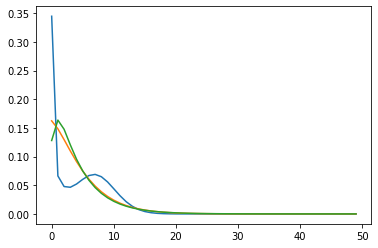

In [13]:
plt.plot(Pss_tele)
plt.plot(Pss_gou)
plt.plot(Pss_cir)

In [14]:
print((Pss_tele.sum(1)*x).sum())
print((Pss_gou.sum(1)*x).sum())
print((Pss_cir.sum(1)*x).sum())


4.166666819545542
4.165914645377943
4.165691387137144


In [15]:
print((Pss_tele.sum(1)*x**2).sum() - (Pss_tele.sum(1)*x).sum()**2)
print((Pss_gou.sum(1)*x**2).sum() - (Pss_gou.sum(1)*x).sum()**2)
print((Pss_cir.sum(1)*x**2).sum() - (Pss_cir.sum(1)*x).sum()**2)


17.187487995048926
17.18435841299372
17.17146794619267


### Sampling and evaluation

In [40]:
def sample_from_p(num_data_points, Pss):
    mx = Pss.shape
    p_flat = Pss.flatten()
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M

def get_logL_1d(d,x,y,K_avg,beta,xyfun,model,mx,dryrun=False):
    mx_eval = [mx[0],1]
    pars = xyfun(x,y,K_avg,beta)
    if dryrun:
        print(pars)
        return 0
    Pss = model.get_Pss(*pars,1,mx_eval)
    Pss = Pss.squeeze()
    logL = np.sum(np.log(Pss[d]))
    return logL


def get_logL_2d(d0,d1,x,y,K_avg,beta,gamma,xyfun,model,mx,dryrun=False):
    mx_eval = mx
    pars = xyfun(x,y,K_avg,beta,gamma)
    if dryrun:
        print(pars)
        return 0
    Pss = model.get_Pss(*pars,mx_eval)
    Pss = Pss.squeeze()
    logL = np.sum(np.log(Pss[d0,d1]))
    return logL

# Parameter regimes

In [77]:
kappa = 0.1
beta = 0.8 
gamma = 0.9
theta = 1
a = 0.4
mx = [50,51]

In [78]:
gou_model = GOUModel()
Pss_gou_true = gou_model.get_Pss(a,kappa,theta,beta,gamma,mx)


In [79]:
xtrue1,ytrue1,K_avg,beta = encode_xy_sde_1d(a, kappa, theta,beta)
xtrue2,ytrue2,K_avg,beta,gamma = encode_xy_sde_2d(a, kappa, theta,beta,gamma)

In [80]:
nCells = 200
nTrials = 1
num_data_points = (nCells,nTrials)

In [81]:
K_avg

4.0

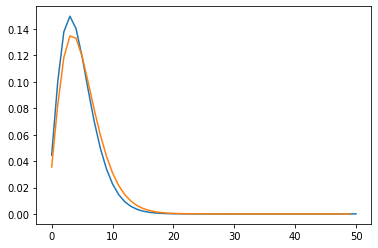

In [82]:
plt.plot(Pss_gou_true.sum(0))
plt.plot(Pss_gou_true.sum(1))

In [83]:
data = sample_from_p(num_data_points,Pss_gou_true) #don't rerun this

In [84]:
nX = 14
nY = 15
x_ = np.linspace(0.01,0.99,nX)
y_ = np.linspace(0.01,0.99,nY)
X,Y = np.meshgrid(x_,y_,indexing='ij')
logL_1d = np.zeros((nX,nY))
logL_2d = np.zeros((nX,nY))

In [88]:

for i,x in enumerate(x_):
    for j,y in enumerate(y_):
        logL_1d[i,j] = get_logL_1d(data[0][:,0],x,y,K_avg,beta,decode_xy_sde_1d,gou_model,mx)
        logL_2d[i,j] = get_logL_2d(data[0][:,0],data[1][:,0],x,y,K_avg,beta,gamma,decode_xy_sde_2d,gou_model,mx)

In [ ]:
# import pickle
# with open('./data/gg230221_logLs.pickle', "wb") as logLfs:
#     pickle.dump((logL_1d,logL_2d), logLfs)


In [89]:
import pickle
with open('./data/gg230221_logLs.pickle', "rb") as logLfs:
    (logL_1d,logL_2d) = pickle.load( logLfs)


In [90]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from matplotlib.patches import Rectangle

# c1 = [0,0,0,0]
# # c2 = [1,1,1,1]
# c2 = [235/255,228/255,143/255,1]
# ncol=2
# cmap_highlight = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(4)]).T)
colors = [(1,0,0,c) for c in np.linspace(0,1,100)]
cmap_highlight = LinearSegmentedColormap.from_list('mycmap', colors, N=5)

cmap_logl = 'cividis'
# color_highlight = cmap_highlight
fs = 12
colors_transp = [(1,1,1,c) for c in np.linspace(1,1,100)]
cmap_highlight = LinearSegmentedColormap.from_list('mycmap', colors_transp, N=5)
regime_ms = 300

dim_names = ('Timescale separation','Noise intensity')
# dim_names = (r'$\frac{\kappa}{\kappa + \beta}$',r'$\frac{\theta}{\theta + a}$')

In [32]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [140]:
import matplotlib
c_coord = 0.7
c_true = matplotlib.colormaps['Reds'](c_coord)[:3]
c_false =  matplotlib.colormaps['Blues'](c_coord)[:3]

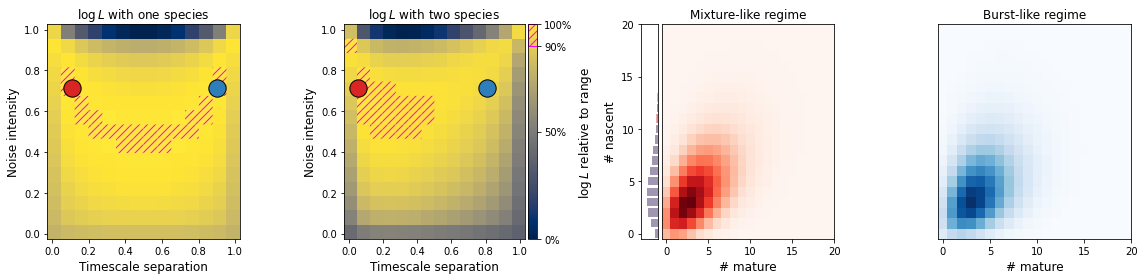

In [156]:
fig1,ax1 = plt.subplots(1,4,figsize=(16,4))
vmin,vmax = (logL_1d.min(),logL_1d.max())
ax1[0].pcolormesh(X,Y,(logL_1d),cmap=cmap_logl,vmin=vmin,vmax=vmax)
q = np.quantile(logL_1d,0.9)
ax1[0].pcolor(X,Y,np.ma.masked_array(logL_1d,logL_1d<q),
              cmap=cmap_logl,
              alpha=1,hatch='///',edgecolor='magenta',facecolor=None,linewidth=0,
              vmin=vmin,vmax=vmax)
# ax1[0].pcolormesh(X,Y,np.ma.masked_array(logL_1d,logL_1d<q),cmap=cmap_highlight,alpha=0.5)
ax1[0].scatter(xtrue1,ytrue1,regime_ms,color=c_true,edgecolors='k')

xfalse1 = 0.9
yfalse1 = ytrue1
ax1[0].scatter(xfalse1,yfalse1,regime_ms,color=c_false,edgecolors='k')
ax1[0].set_title(r'$\log L$ with one species',fontsize=fs)
ax1[0].set_xlabel(dim_names[0],fontsize=fs)
ax1[0].set_ylabel(dim_names[1],fontsize=fs)

##################################
xfalse2,yfalse2,K_avg,beta,gamma =  encode_xy_sde_2d(*decode_xy_sde_1d(xfalse1,yfalse1,K_avg,beta),gamma)

vmin,vmax = (logL_2d.min(),logL_2d.max())
mesh = ax1[1].pcolormesh(X,Y,(logL_2d),cmap=cmap_logl,vmin=vmin,vmax=vmax)
q = np.quantile(logL_2d,0.9)
ax1[1].pcolor(X,Y,np.ma.masked_array(logL_2d,logL_2d<q),
              cmap=cmap_logl,
              alpha=1,hatch='///',edgecolor='magenta',facecolor=None,linewidth=0,
              vmin=vmin,vmax=vmax)
ax1[1].scatter(xtrue2,ytrue2,regime_ms,color=c_true,edgecolors='k')
ax1[1].scatter(xfalse2,yfalse2,regime_ms,color=c_false,edgecolors='k')
ax1[1].set_title(r'$\log L$ with two species',fontsize=fs)
ax1[1].set_xlabel(dim_names[0],fontsize=fs)
ax1[1].set_ylabel(dim_names[1],fontsize=fs)


divider = make_axes_locatable(ax1[1])
# cax = divider.append_axes('right', size='10%', pad=0.05)
cax = divider.append_axes('right', size='5%', pad=0.05)
# cax.plot([0,1],[1/3]*2,'w',linewidth=3)
# cax.plot([0,1],[1/2]*2,'w',linewidth=3)
fig1.colorbar(mesh,cax =cax)
cax.set_ylabel(r'$\log L$ relative to range',fontsize=fs)
caxlims = np.asarray([logL_2d.min(),logL_2d.max()])
# print([caxlims[0],caxlims.mean(), np.diff(caxlims)[0]*0.9+caxlims[0], caxlims[1]])
dl = np.diff(caxlims)[0]
cax.set_yticks([caxlims[0],caxlims.mean(), dl*0.9+caxlims[0], caxlims[1]],['0%','50%','90%','100%'])
cax.add_patch(Rectangle((0, dl*0.9+caxlims[0]), 1, dl*0.1, fill=False, hatch='///',edgecolor='magenta'))

# cax.plot(Pvals_true,xvals,'r')
# cax.plot(Pvals_false,xvals,'b')
# cax_mx = max(Pvals_false.max(),Pvals_true.max())
# cax.set_xlim([0,cax_mx*1.5])
# cax.invert_xaxis()
# cax.set_xticks([])
# cax.set_yticks(np.arange(0,21,5))
# cax.set_ylabel('# nascent',fontsize=fs

################################
Pss_gou_false = gou_model.get_Pss(*decode_xy_sde_2d(xfalse2,yfalse2,K_avg,beta,gamma),mx)

xvals = np.arange(mx[0])
Pvals_true = Pss_gou_true.sum(1)
Pvals_false = Pss_gou_false.sum(1)

divider = make_axes_locatable(ax1[2])
cax = divider.append_axes('left', size='10%', pad=0.05)

cax.barh(xvals,Pvals_true,color=c_true,align='center',alpha=0.4)
cax.barh(xvals,Pvals_false,color=c_false,align='center',alpha=0.4)
# cax.plot(Pvals_true,xvals,color=c_true)
# cax.plot(Pvals_false,xvals,color=c_false,linestyle='--')
cax_mx = max(Pvals_false.max(),Pvals_true.max())
cax.set_xlim([0,cax_mx*1.5])
cax.invert_xaxis()
cax.set_xticks([])
cax.set_yticks(np.arange(0,21,5))
cax.set_ylabel('# nascent',fontsize=fs)


ax1[2].imshow((Pss_gou_true),cmap='Reds',aspect='auto')
ax1[2].invert_yaxis()
ax1[2].set_yticks([])
ax1[2].set_xlabel('# mature',fontsize=fs)
ax1[2].set_title('Mixture-like regime',fontsize=fs)


ax1[3].imshow((Pss_gou_false),cmap='Blues',aspect='auto')
ax1[3].invert_yaxis()
ax1[3].set_yticks([])
ax1[3].set_xlabel('# mature',fontsize=fs)
ax1[3].set_title('Burst-like regime',fontsize=fs)


lims = [-0.5,20]
ax1[2].set_xlim(lims)
ax1[2].set_ylim(lims)
ax1[3].set_xlim(lims)
ax1[3].set_ylim(lims)
cax.set_ylim(lims)

fig1.tight_layout()
plt.savefig('figs/fig4b.png',dpi=450)
plt.savefig('figs/fig4b.pdf')

In [151]:
# Pvals_true

# AIC

In [35]:
# kappa = 0.1
beta = 0.8 
gamma = 0.9
# theta = 1
# a = 0.4
mx = [50,51]
K_avg = 5

In [36]:
import warnings
warnings.filterwarnings("error")


In [66]:
nCells = 200
nTrials = 50
num_data_points = (nCells,nTrials)
telegraph_model = TelegraphModel()
gou_model = GOUModel()
cir_model = CIRModel()
model_names = (r'$\Gamma$-OU','CIR','Telegraph')
models = [gou_model, cir_model, telegraph_model]
decode_fun_1d = [decode_xy_sde_1d,decode_xy_sde_1d,decode_xy_tele_1d]
decode_fun_2d = [decode_xy_sde_2d,decode_xy_sde_2d,decode_xy_tele_2d]
true_model = models[0]


In [67]:
# nX = 4
# nY = 5
nX = 14
nY = 15
x_ = np.linspace(0.01,0.99,nX)
y_ = np.linspace(0.01,0.99,nY)
nmod = 3
Xaic,Yaic = np.meshgrid(x_,y_,indexing='ij')


In [68]:
logL_1d_AIC = np.zeros((nX,nY,nmod,nTrials))
logL_2d_AIC = np.zeros((nX,nY,nmod,nTrials))
dryrun=False
for i,x in enumerate(x_):
    print(i)
    for j,y in enumerate(y_):
        Pss_true = true_model.get_Pss(*decode_xy_sde_2d(x,y,K_avg,beta,gamma),mx)
        data = sample_from_p(num_data_points,Pss_true)
        for k in range(nmod):
            for trial in range(nTrials):
                logL_1d_AIC[i,j,k,trial] = get_logL_1d(data[0][:,trial],x,y,K_avg,beta,decode_fun_1d[k],models[k],mx,dryrun=dryrun)                
                logL_2d_AIC[i,j,k,trial] = get_logL_2d(data[0][:,trial],data[1][:,trial],x,y,K_avg,beta,gamma,decode_fun_2d[k],models[k],mx,dryrun=dryrun)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [69]:
import pickle

In [70]:
with open('./data/gg230221_aics_50trials.pickle', "wb") as aicfs:
    pickle.dump((logL_1d_AIC,logL_2d_AIC), aicfs)


In [71]:
with open('./data/gg230221_aics_50trials.pickle', "rb") as aicfs:
    logL_1d_AIC,logL_2d_AIC  = pickle.load(aicfs)


In [72]:
AIC_values = -2*logL_1d_AIC 
AICmin = np.amin(AIC_values,2)
dAIC = AIC_values-AICmin[:,:,None,:]
AIC = np.exp(-dAIC/2)
AIC /= AIC.sum(2)[:,:,None,:]
Z_1d = AIC[:,:,0,:].mean(-1)

AIC_values = -2*logL_2d_AIC 
AICmin = np.amin(AIC_values,2)
dAIC = AIC_values-AICmin[:,:,None,:]
AIC = np.exp(-dAIC/2)
AIC /= AIC.sum(2)[:,:,None,:]
Z_2d = AIC[:,:,0,:].mean(-1)

In [73]:
from matplotlib import colors

cmap_aic = 'plasma'
fs = 12
cmap = colors.ListedColormap(['white', 'magenta','blue'])
bounds=[0,1/3,1/2,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

model_colors = ['cadetblue','limegreen','goldenrod']
regime_colors = ['darkolivegreen','deeppink']
regime_ms = 300
noise_ms = 100
noise_color='darkgray'
noiseline_colors = ['darkgray','dimgray']
noiseline_width = [3,5]
head_width=0.03
import matplotlib.patheffects as pe
from matplotlib.patches import Rectangle


In [74]:
warnings.resetwarnings()


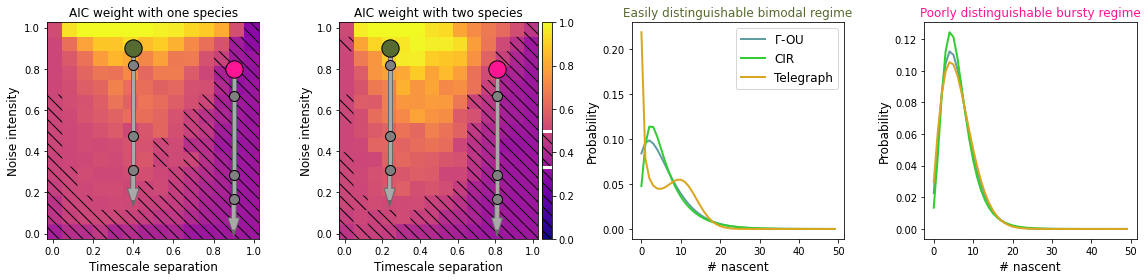

In [75]:
fig1,ax1 = plt.subplots(1,4,figsize=(16,4))

mesh = ax1[0].pcolormesh(Xaic,Yaic,Z_1d,cmap=cmap_aic,vmin=0,vmax=1)
ax1[0].pcolor(Xaic,Yaic,np.ma.masked_array(Z_1d,Z_1d>1/2),
              cmap=cmap_aic,
              alpha=1,hatch='\\\\',edgecolor='black',facecolor=None,linewidth=0,
              vmin=0,vmax=1)


x1_1d = 0.4
y1_1d = 0.9

x2_1d = 0.9
y2_1d = 0.8

ax1[0].set_xlabel(dim_names[0],fontsize=fs)
ax1[0].set_ylabel(dim_names[1],fontsize=fs)
ax1[0].set_title('AIC weight with one species',fontsize=fs)
################
pars_1 = decode_xy_sde_1d(x1_1d,y1_1d,K_avg,beta)
noise_corr_1 = []
for p_val in [1,0.5,0.1,0.05]:
    pars_new = np.copy(pars_1)
    pars_new[2] *= p_val
    x,y,_,_ = encode_xy_sde_1d(*pars_new)
    noise_corr_1.append([x,y])
noise_corr_1 = np.asarray(noise_corr_1)
ax1[0].plot(noise_corr_1[:,0],noise_corr_1[:,1],'-',
            linewidth=noiseline_width[0],color=noiseline_colors[0],
            path_effects=[pe.Stroke(linewidth=noiseline_width[1], foreground=noiseline_colors[1]), pe.Normal()])
ax1[0].arrow(noise_corr_1[-1,0],noise_corr_1[-1,1],0,-0.1,
            head_width = head_width,
            linewidth=noiseline_width[0],color=noiseline_colors[0],
            path_effects=[pe.Stroke(linewidth=noiseline_width[1], foreground=noiseline_colors[1]), pe.Normal()])
ax1[0].scatter(noise_corr_1[1:,0],noise_corr_1[1:,1],s=noise_ms,c='gray',edgecolors='k',zorder=1000)
#########
pars_2 = decode_xy_sde_1d(x2_1d,y2_1d,K_avg,beta)
noise_corr_2 = []
for p_val in [1,0.5,0.1,0.05]:
    pars_new = np.copy(pars_2)
    pars_new[2] *= p_val
    x,y,_,_ = encode_xy_sde_1d(*pars_new)
    noise_corr_2.append([x,y])
noise_corr_2 = np.asarray(noise_corr_2)
ax1[0].plot(noise_corr_2[:,0],noise_corr_2[:,1],'-',
            linewidth=noiseline_width[0],color=noiseline_colors[0],
            path_effects=[pe.Stroke(linewidth=noiseline_width[1], foreground=noiseline_colors[1]), pe.Normal()])
ax1[0].arrow(noise_corr_2[-1,0],noise_corr_2[-1,1],0,-0.1,
            head_width = head_width,
            linewidth=noiseline_width[0],color=noiseline_colors[0],
            path_effects=[pe.Stroke(linewidth=noiseline_width[1], foreground=noiseline_colors[1]), pe.Normal()])
ax1[0].scatter(noise_corr_2[1:,0],noise_corr_2[1:,1],s=noise_ms,c='gray',edgecolors='k',zorder=1000)
#########
ax1[0].scatter(x1_1d,y1_1d,regime_ms,regime_colors[0],edgecolors='k',zorder=1000)
ax1[0].scatter(x2_1d,y2_1d,regime_ms,regime_colors[1],edgecolors='k',zorder=1000)
#########

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax1[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cax.plot([0,1],[1/3]*2,'w',linewidth=3)
cax.plot([0,1],[1/2]*2,'w',linewidth=3)
fig1.colorbar(mesh,cax =cax)
cax.add_patch(Rectangle((0, 0), 1, 1/2, fill=False, hatch='\\\\'))

# ####################################

ax1[1].set_title('AIC weight with two species',fontsize=fs)

ax1[1].pcolormesh(Xaic,Yaic,Z_2d,cmap=cmap_aic,vmin=0,vmax=1)
ax1[1].pcolor(Xaic,Yaic,np.ma.masked_array(Z_2d,Z_2d>1/2),
              cmap=cmap_aic,
              alpha=1,hatch='\\\\',edgecolor='black',facecolor=None,linewidth=0,
              vmin=0,vmax=1)

x1_2d,y1_2d,_,_,_ =  encode_xy_sde_2d(*decode_xy_sde_1d(x1_1d,y1_1d,K_avg,beta),gamma)
x2_2d,y2_2d,_,_,_ =  encode_xy_sde_2d(*decode_xy_sde_1d(x2_1d,y2_1d,K_avg,beta),gamma)
################
pars_1 = decode_xy_sde_1d(x1_2d,y1_2d,K_avg,beta)
noise_corr_1 = []
for p_val in [1,0.5,0.1,0.05]:
    pars_new = np.copy(pars_1)
    pars_new[2] *= p_val
    x,y,_,beta = encode_xy_sde_1d(*pars_new)
    noise_corr_1.append([x,y])
noise_corr_1 = np.asarray(noise_corr_1)
ax1[1].plot(noise_corr_1[:,0],noise_corr_1[:,1],'-',
            linewidth=noiseline_width[0],color=noiseline_colors[0],
            path_effects=[pe.Stroke(linewidth=noiseline_width[1], foreground=noiseline_colors[1]), pe.Normal()])
ax1[1].arrow(noise_corr_1[-1,0],noise_corr_1[-1,1],0,-0.1,
            head_width = head_width,
            linewidth=noiseline_width[0],color=noiseline_colors[0],
            path_effects=[pe.Stroke(linewidth=noiseline_width[1], foreground=noiseline_colors[1]), pe.Normal()])
ax1[1].scatter(noise_corr_1[1:,0],noise_corr_1[1:,1],s=noise_ms,c='gray',edgecolors='k',zorder=1000)
#########
pars_2 = decode_xy_sde_1d(x2_2d,y2_2d,K_avg,beta)
noise_corr_2 = []
for p_val in [1,0.5,0.1,0.05]:
    pars_new = np.copy(pars_2)
    pars_new[2] *= p_val
    x,y,_,_ = encode_xy_sde_1d(*pars_new)
    noise_corr_2.append([x,y])
noise_corr_2 = np.asarray(noise_corr_2)
ax1[1].plot(noise_corr_2[:,0],noise_corr_2[:,1],'-',
            linewidth=noiseline_width[0],color=noiseline_colors[0],
            path_effects=[pe.Stroke(linewidth=noiseline_width[1], foreground=noiseline_colors[1]), pe.Normal()])
ax1[1].arrow(noise_corr_2[-1,0],noise_corr_2[-1,1],0,-0.1,
            head_width = head_width,
            linewidth=noiseline_width[0],color=noiseline_colors[0],
            path_effects=[pe.Stroke(linewidth=noiseline_width[1], foreground=noiseline_colors[1]), pe.Normal()])
ax1[1].scatter(noise_corr_2[1:,0],noise_corr_2[1:,1],s=noise_ms,c='gray',edgecolors='k',zorder=1000)
#########
ax1[1].scatter(x1_2d,y1_2d,regime_ms,regime_colors[0],edgecolors='k',zorder=1000)
ax1[1].scatter(x2_2d,y2_2d,regime_ms,regime_colors[1],edgecolors='k',zorder=1000)
#########

ax1[1].set_xlabel(dim_names[0],fontsize=fs)
ax1[1].set_ylabel(dim_names[1],fontsize=fs)
# #####################################

xvals = np.arange(mx[0])
Pss_arr_1 = [models[k].get_Pss(*decode_fun_2d[k](x1_2d,y1_2d,K_avg,beta,gamma),[mx[0],1]) for  k in range(nmod)]
for k in range(3):
    ax1[2].plot(xvals,Pss_arr_1[k],label=model_names[k],linewidth=2,color=model_colors[k])
ax1[2].legend(fontsize=fs)
ax1[2].set_xlabel('# nascent',fontsize=fs)
ax1[2].set_ylabel('Probability',fontsize=fs)
ax1[2].set_title('Easily distinguishable bimodal regime',fontsize=fs,color=regime_colors[0])



xvals = np.arange(mx[0])
Pss_arr_2 = [models[k].get_Pss(*decode_fun_2d[k](x2_2d,y2_2d,K_avg,beta,gamma),[mx[0],1]) for  k in range(nmod)]
for k in range(3):
    ax1[3].plot(xvals,Pss_arr_2[k],linewidth=2,color=model_colors[k])
ax1[3].set_xlabel('# nascent',fontsize=fs)
ax1[3].set_ylabel('Probability',fontsize=fs)
ax1[3].set_title('Poorly distinguishable bursty regime',fontsize=fs,color=regime_colors[1])

fig1.tight_layout()
plt.savefig('figs/fig4c.png',dpi=450)
plt.savefig('figs/fig4c.pdf')